In [1]:
dir = r'C:\Program Files\mingw-w64\x86_64-7.2.0-posix-seh-rt_v5-rev1\mingw64\bin'
import os
os.environ['PATH'].count(dir)
os.environ['PATH'].find(dir)
os.environ['PATH'] = dir + ';' + os.environ['PATH']
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from haversine import haversine
import datetime as dt

In [2]:
'''Step1: Load Data'''
trainDF = pd.read_csv('data/train.csv', nrows=50000)
testDF = pd.read_csv('data/test.csv')
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", list(trainDF))


Size of the training set is: 50000 rows and 11 columns

 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [3]:
'''Step2: Understand Data'''
df = trainDF.describe()
print (df)

print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

dtypeDF=trainDF.dtypes.reset_index()# reset_index(): When we reset the index, the old index is added as a column, and a new sequential index is usedWhen we reset the index, the old index is added as a column, and a new sequential index is used
dtypeDF.columns=["Count","Column Type"]
dtypeDF.groupby("Column Type").aggregate('count')
print(dtypeDF)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  50000.000000     50000.000000      50000.000000     50000.000000   
mean       1.529440         1.667260        -73.973477        40.751211   
std        0.499138         1.316442          0.037974         0.027994   
min        1.000000         1.000000        -74.393555        40.449749   
25%        1.000000         1.000000        -73.991760        40.737579   
50%        2.000000         1.000000        -73.981644        40.754425   
75%        2.000000         2.000000        -73.967079        40.768513   
max        2.000000         6.000000        -73.518051        41.091171   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       50000.000000      50000.000000   50000.000000  
mean          -73.973374         40.752025     949.708280  
std             0.036672          0.032536    3175.391374  
min           -74.398514         40.444698       1.000000  
25%           -73.991348

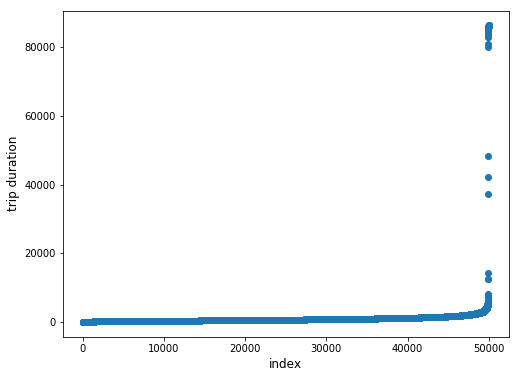

In [4]:
'''Step3: Understanding distribution of target variable i.e trip duration.'''
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))#Y.shape is (n,m). So Y.shape[0] is n.

#Step3.1: Find the outliers & Remove outliers by sorting duration in ascending order:
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

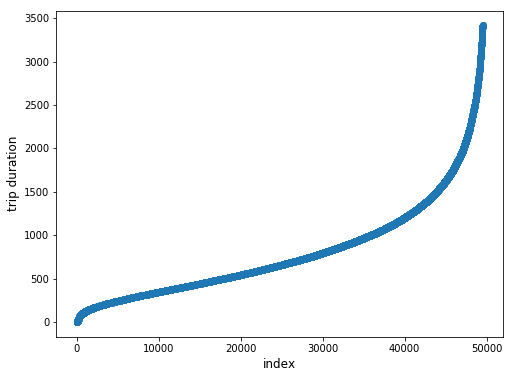

In [5]:
#Step3.2: Catch outliers and replot
th=trainDF.trip_duration.quantile(0.99)
tempDF=trainDF
tempDF=tempDF[tempDF['trip_duration']<th] #!!!!!!!!!!!!!!! Remain the ones <th
plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]),np.sort(tempDF.trip_duration.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('trip duration',fontsize=12)
plt.show()
del tempDF

In [6]:
#Step 4: Dealing with missing values
variable_missing_value=trainDF.isnull().sum()
print('Missing value number of Training DF:\n',variable_missing_value)
variable_missing_value=testDF.isnull().sum()
print('Missing value number of Testing DF:\n',variable_missing_value)

Missing value number of Training DF:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Missing value number of Testing DF:


 id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


In [7]:
#Step 5: Format the date time & Y/N values:
from sklearn.decomposition import PCA
#Principal components analysis (PCA):illustrating how a point cloud can be very flat in one direction–which is where PCA comes in to choose a direction that is not flat.
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()
train = trainDF
test = testDF
del trainDF, testDF

In [8]:
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:,'pickup_date']=train['pickup_datetime'].dt.date
test.loc[:,'pickup_date']=test['pickup_datetime'].dt.date

train['dropoff_datetime']=pd.to_datetime(train.dropoff_datetime)

train['store_and_fwd_flag']=1*(train.store_and_fwd_flag.values=='Y')
test['store_and_fwd_flag']=1*(test.store_and_fwd_flag.values=='Y') #!!!!!!!!!!!!!!!!!
print(list(train))

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date']


In [9]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds()) #!!!!!!!!! 1. New column 2. Convert to seconds.
duration_difference=train[np.abs(train['check_trip_duration'].values-train['trip_duration'].values) > 1] #!!!!!!!!!!!Remain the ones with abs>1
print('Trip_Duration & datetime are ok.')
print(list(train))

Trip_Duration & datetime are ok.
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration']


In [10]:
if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']])==0:
    print('Items of Duration_difference are 0.')

train['trip_duration'].describe()


count    50000.000000
mean       949.708280
std       3175.391374
min          1.000000
25%        395.000000
50%        659.000000
75%       1071.000000
max      86357.000000
Name: trip_duration, dtype: float64

In [11]:
#Step6: Feature Extraction:
coords=np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                  train[['dropoff_latitude', 'dropoff_longitude']].values,
                  test[['pickup_latitude', 'pickup_longitude']].values,
                  test[['dropoff_latitude', 'dropoff_longitude']].values))

pca=PCA().fit(coords)
train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0] 
#transform(X):Apply dimensionality reduction to X.
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]
#[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ],you get all values in column 0 (from all rows).
#df[['a','b']]: select multiple columns.

In [12]:
#Step7: Distance:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2=map(np.radians, (lat1,lng1,lat2,lng2))
    AVG_EARTH_RADIUS=6371 #km
    lat=lat2-lat1
    lng=lng2-lng1
    d=np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h=2*AVG_EARTH_RADIUS*np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1,lng1,lat2,lng2):
    a=haversine_array(lat1,lng1,lat1,lng2)
    b=haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1,lng1,lat2,lng2):
    AVG_EARTH_RADIUS=6371
    lng_delta_rad=np.radians(lng2-lng1)
    lat1,lng1,lat2,lng2=map(np.radians,(lat1,lng1,lat2,lng2)) #np.radians(): Convert angles from degrees to radians
    y=np.sin(lng_delta_rad)*np.cos(lat2)
    x=np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

In [13]:
print('train headers:\n',list(train))
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2


train headers:
 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']


In [14]:
#Step8: Datetime features:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_hour_weekofyear']=train['pickup_datetime'].dt.weekofyear
train.loc[:,'pickup_hour']=train['pickup_datetime'].dt.hour
train.loc[:,'pickup_minute']=train['pickup_datetime'].dt.minute
train.loc[:,'pickup_dt']=(train['pickup_datetime']-train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:,'pickup_week_hour']=train['pickup_weekday']*24+train['pickup_hour']

test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_hour_weekofyear']=test['pickup_datetime'].dt.weekofyear
test.loc[:,'pickup_hour']=test['pickup_datetime'].dt.hour
test.loc[:,'pickup_minute']=test['pickup_datetime'].dt.minute
test.loc[:,'pickup_dt']=(test['pickup_datetime']-test['pickup_datetime'].min()).dt.total_seconds()
test.loc[:,'pickup_week_hour']=test['pickup_weekday']*24+test['pickup_hour']

train.loc[:,'week_delta']=train['pickup_datetime'].dt.weekday+((train['pickup_datetime'].dt.hour+(train['pickup_datetime'].dt.minute/60.0))/24.0)
test.loc[:,'week_delta']=test['pickup_datetime'].dt.weekday+((test['pickup_datetime'].dt.hour+(test['pickup_datetime'].dt.minute/60.0))/24.0)


In [15]:
#Step 8.1: Make time cyclic:
train.loc[:,'week_delta_sin']=np.sin((train['week_delta']/7)*np.pi)**2
train.loc[:,'hour_sin']=np.sin((train['pickup_hour']/24)*np.pi)**2
test.loc[:,'week_delta_sin']=np.sin((test['week_delta']/7)*np.pi)**2
test.loc[:,'hour_sin']=np.sin((test['pickup_hour']/24)*np.pi)**2

In [16]:
#Step9: Speed processing:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],3)


In [17]:
#Step9.1: Average speed for regions:
gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index() #!!!!!!!reset_index()
coord_stats=pd.merge(coord_speed, coord_count,on=gby_cols)
coord_stats=coord_stats[coord_stats['id']>100]

train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)
train.loc[:,'pickup_dt_bin']=(train['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)
test.loc[:,'pickup_dt_bin']=(test['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line


In [18]:
#Step10: Clustering-MiniBatchKMeans:
sample_ind=np.random.permutation(len(coords))[:500000]
#np.random.permutation: Randomly permute a sequence, or return a permuted range.
#Shuffle the coords and get 500000 items from it.

print('length of coords:\n', len(coords))
kmeans=MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
#MiniBatchKMeans: batch_size controls the number of randomly selected observations in each batch. The larger the the size of the batch, the more computationally costly the training process.


length of coords:
 1350268


In [19]:
#Step10.1: Predict by MiniBatchKMeans:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

t1=dt.datetime.now()
print('Time for clustering: %i seconds' %(t1-t0).seconds) #!!!!!!!!!!!!!!!!!!!!


Time for clustering: 211 seconds


In [20]:
train['log_trip_duration']=np.log(train['trip_duration'].values+1)

In [21]:
print(list(test))
print("\n")
print("Train:")
print(list(train))
print(train.head(3))

['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_cluster', 'dropoff_cluster']


Train:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direct

In [22]:
#Step11: Temporal and geospatial aggregation
for gby_col in ['pickup_hour','pickup_date','pickup_dt_bin','pickup_week_hour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_col).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns=['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train=pd.merge(train, gby,how='left',left_on=gby_col,right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    #how: left: use only keys from left frame, similar to a SQL left outer join; preserve key order
    #right_index: Use the index from the right DataFrame as the join key.
    #left_on 和 right_on 来指定列名，从而使不同的列名相互对应，进而进行合并. 如employee, name.


for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats=pd.merge(coord_speed,coord_count,on=gby_cols)
    coord_stats.columns=gby_cols+['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    #.columns attribute returns an index containg the column names of df.df. columns可以得到所有的列标签，同理df.index可以得到所有的行标签。
    #eg.:df.columns: Get: Index(['ColumnOne', 'ColumnTwo'], dtype=
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)
 

In [23]:
   
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag          ...            \
0         40.765602                   0          ...             
1         40.731152                   0          ...             
2         40.710087                   0          ...             

   cnt_center_lat_bin_center_long_bin  \
0                                2020   
1                                1803   
2                                2823 

In [24]:
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag     ...       \
0         40.765602                   0     ...        
1         40.731152                   0     ...        
2         40.710087                   0     ...        

   avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406        
1                                           3.419741        
2                 

In [25]:
# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

In [26]:
train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [27]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

In [28]:
train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)


In [30]:
# For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ 
# "OSRM")) features. This data contains the fastest routes from specific starting points in NY.

fr1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])

fr2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

test_street_info = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])


In [31]:
train_street_info=pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag       ...         \
0         40.765602                   0       ...          
1         40.731152                   0       ...          
2         40.710087                   0       ...          

   cnt_pickup_hour_dropoff_cluster avg_speed_h_pickup_cluster_dropoff_cluster  \
0                               43                                   3.269584   
1                      

In [32]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 62 features.
Feature extraction time: 341 seconds


In [33]:
feature_stats = pd.DataFrame({'feature': feature_names})

feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()


,feature,train_test_mean_diff
55,cnt_pickup_cluster_dropoff_cluster,0.027371
51,cnt_pickup_hour_pickup_cluster,0.030921
54,avg_speed_h_pickup_cluster_dropoff_cluster,0.033199
53,cnt_pickup_hour_dropoff_cluster,0.040243
48,avg_speed_h_pickup_hour_center_lat_bin_center_...,0.045448


In [34]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=9, verbosity=2)
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


C:\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [35]:
# Split the training data to train and validate

# K Fold Cross Validation
from sklearn.model_selection import KFold

X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1) 

kf = KFold(n_splits=10)
kf.get_n_splits(X)

print("feature names:\n", feature_names)
print("x:\n",X)
print("y:\n",y)
print(kf)  


feature names:


['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

x:


[[  2.00000000e+00   1.00000000e+00  -7.39821549e+01 ...,   2.00910000e+03
    1.64900000e+02   5.00000000e+00]
 [  1.00000000e+00   1.00000000e+00  -7.39804153e+01 ...,   2.51320000e+03
    3.32000000e+02   6.00000000e+00]
 [  2.00000000e+00   1.00000000e+00  -7.39790268e+01 ...,   1.10608000e+04
    7.67600000e+02   1.60000000e+01]
 ..., 
 [  1.00000000e+00   1.00000000e+00  -7.39679794e+01 ...,   5.20500000e+03
    5.20000000e+02   6.00000000e+00]
 [  2.00000000e+00   2.00000000e+00  -7.37767410e+01 ...,   1.89727000e+04
    1.17050000e+03   1.70000000e+01]
 [  1.00000000e+00   2.00000000e+00  -7.40147934e+01 ...,   3.93740000e+03
    4.24700000e+02   6.00000000e+00]]

y:


[ 6.12249281  6.49828215  7.66152708 ...,  6.85856503  7.47363711
  6.42162227]

KFold(n_splits=10, random_state=None, shuffle=False)

In [36]:
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

TRAIN:

[ 5000  5001  5002 ..., 49997 49998 49999]

TEST:

[   0    1    2 ..., 4997 4998 4999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[5000 5001 5002 ..., 9997 9998 9999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[10000 10001 10002 ..., 14997 14998 14999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[15000 15001 15002 ..., 19997 19998 19999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[20000 20001 20002 ..., 24997 24998 24999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[25000 25001 25002 ..., 29997 29998 29999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[30000 30001 30002 ..., 34997 34998 34999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[35000 35001 35002 ..., 39997 39998 39999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[40000 40001 40002 ..., 44997 44998 44999]

TRAIN:

[    0     1     2 ..., 44997 44998 44999]

TEST:

[45000 45001 45002 ..., 49997 49998 49999]

In [37]:
auto_classifier.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/36 [00:00<?, ?pipeline/s]

Optimization Progress:   3%|▎         | 1/36 [02:45<1:36:47, 165.92s/pipeline]

Optimization Progress:   6%|▌         | 2/36 [06:42<1:46:00, 187.08s/pipeline]

Optimization Progress:   8%|▊         | 3/36 [06:53<1:13:48, 134.19s/pipeline]

Optimization Progress:  11%|█         | 4/36 [12:12<1:41:09, 189.68s/pipeline]

Optimization Progress:  17%|█▋        | 6/36 [12:14<1:06:31, 133.04s/pipeline]

Optimization Progress:  19%|█▉        | 7/36 [17:14<1:28:35, 183.29s/pipeline]

Optimization Progress:  25%|██▌       | 9/36 [21:22<1:14:28, 165.49s/pipeline]

Optimization Progress:  28%|██▊       | 10/36 [21:27<50:50, 117.33s/pipeline] 

Optimization Progress:  31%|███       | 11/36 [21:34<35:02, 84.10s/pipeline] 

Optimization Progress:  33%|███▎      | 12/36 [26:55<1:02:08, 155.34s/pipeline]

Optimization Progress:  36%|███▌      | 13/36 [29:07<59:32, 155.34s/pipeline]


TPOT closed prematurely. Will use the current best pipeline.

Optimization Progress:  36%|███▌      | 13/36 [29:07<59:32, 155.34s/pipeline]

In [75]:
print(feature_names)
print(test[feature_names].head(5))
test[feature_names].to_csv('NYCTaxi_DataTest.csv', index=False)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_pca0  \
0         -73.990173         40.756680                   0     0.016106   
1         -73.959808         40.655403                   0    -0.003569   
2         -73.986160         40.729523                   0     0.024939   
3         -73.986427         40.730469                   0    -0.019047   
4         -73.961510         40.755890                   0    -0.004111   

   pickup_pca1  dropoff_pca0       ...         \
0    -0.018128      0.016167       ...          
1    -0.071915     -0.005977       ...    

In [78]:
test_result = auto_classifier.predict(test[feature_names].values)
sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = np.exp(test_result)
sub['pickup_weekday']=test['pickup_weekday']
sub.to_csv('NYCTaxi_TpotModels.csv', index=False)
sub.head()
      
auto_classifier.export('NYCTaxi_TPOTpipelineResult.py')

Imputing missing values in feature set

True

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics

exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=13, min_samples_split=12, n_estimators=100)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_valid)



C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'X_train' is not defined